In [1]:
from __future__ import print_function

import linecache

import torch
import torch.utils.data as data

import pickle, time, os,sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import matplotlib


class ESImagenet_Dataset(data.Dataset):
    def __init__(self, mode, data_set_path='/data/dvsimagenet/'):
        super().__init__()
        self.mode = mode
        self.filenames = []
        self.trainpath = data_set_path+'train'
        self.testpath = data_set_path+'val'
        self.traininfotxt = data_set_path+'trainlabel.txt'
        self.testinfotxt = data_set_path+'vallabel.txt'
        self.formats = '.npz'
        if mode == 'train':
            self.path = self.trainpath
            trainfile = open(self.traininfotxt, 'r')
            for line in trainfile:
                filename, classnum, a, b = line.split()
                realname,sub = filename.split('.')
                self.filenames.append(realname+self.formats)
        else:
            self.path = self.testpath
            testfile = open(self.testinfotxt, 'r')
            for line in testfile:
                filename, classnum, a, b = line.split()
                realname,sub = filename.split('.')
                self.filenames.append(realname+self.formats)

    def __getitem__(self, index):
        if self.mode == 'train':
            info = linecache.getline(self.traininfotxt, index+1)
        else:
            info = linecache.getline(self.testinfotxt, index+1)
        filename, classnum, a, b = info.split()
        realname,sub = filename.split('.')
        filename = realname+self.formats
        filename = self.path + r'/' + filename
        classnum = int(classnum)
        a = int(a)
        b = int(b)
        datapos = np.load(filename)['pos'].astype(np.float64)
        dataneg = np.load(filename)['neg'].astype(np.float64)

        
        dy = (254 - b) // 2
        dx = (254 - a) // 2
        input = torch.zeros([8, 2, 256, 256])

        x = datapos[:,0]+ dx
        y = datapos[:,1]+ dy
        t = datapos[:,2]-1
        input[t ,0,x ,y ] = 1
        
        x = dataneg[:,0]+ dx
        y = dataneg[:,1]+ dy
        t = dataneg[:,2]-1
        input[t ,1,x ,y ] = 1

        reshape = input[:,:,16:240,16:240]
        label = torch.tensor([classnum])
        return reshape, label

    def __len__(self):
        return len(self.filenames)





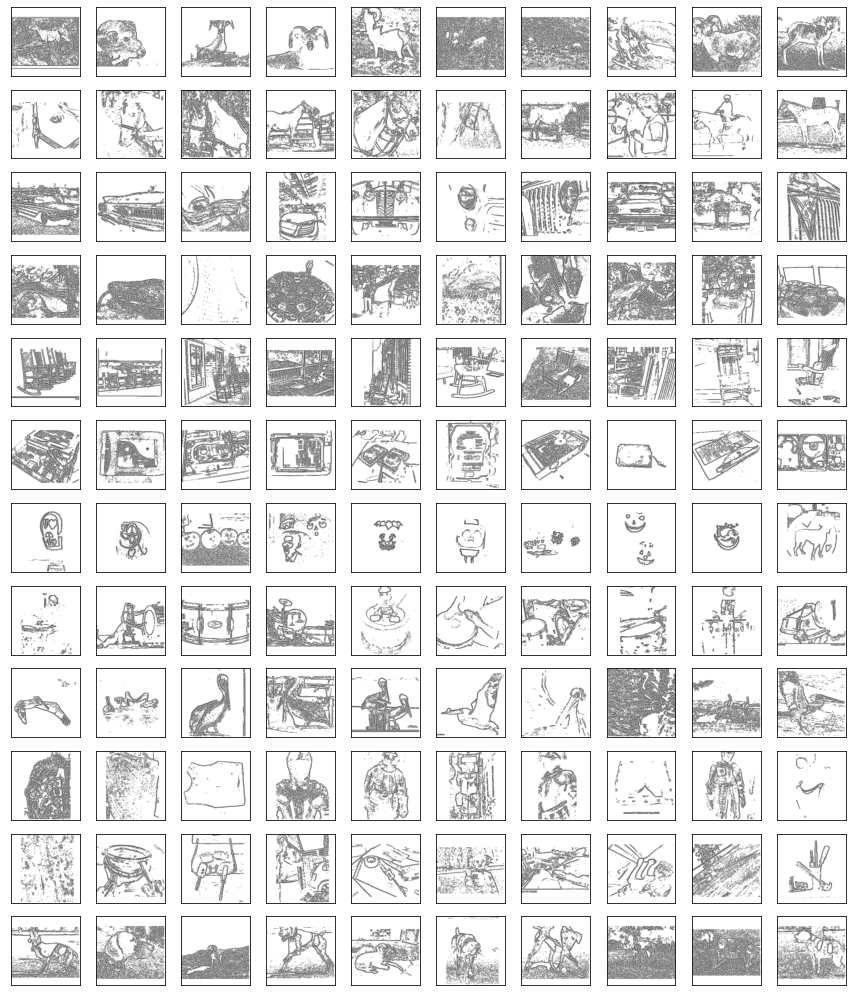

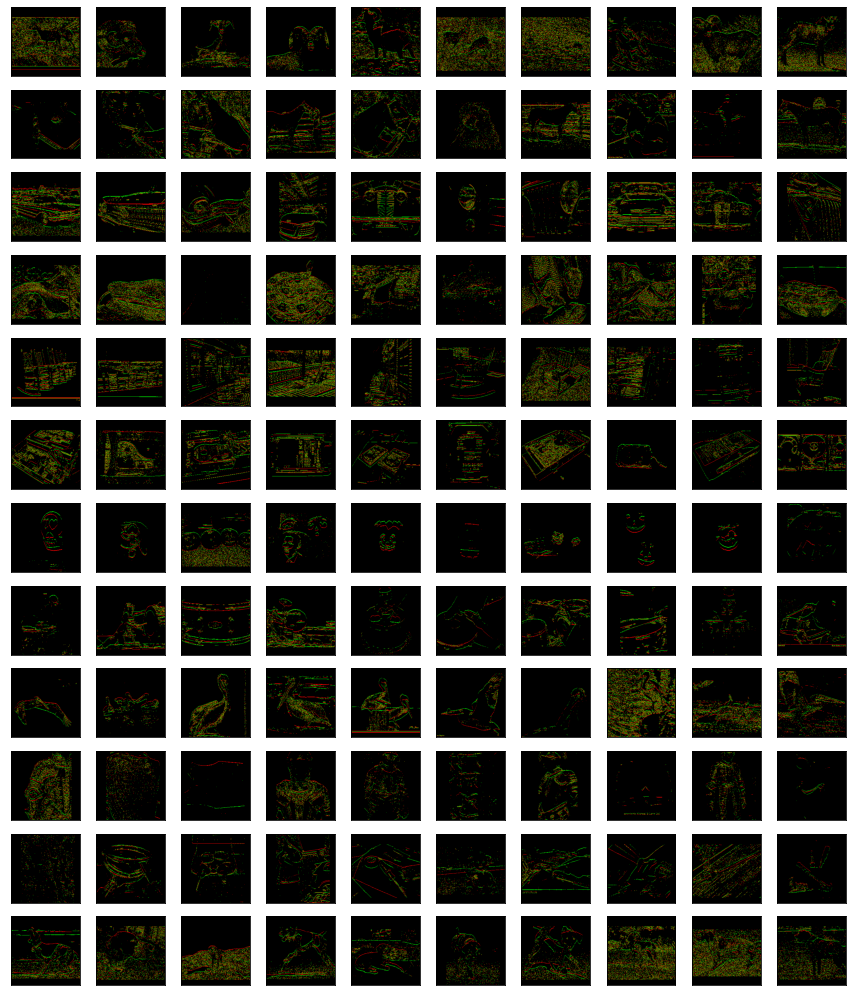

<Figure size 1080x1296 with 0 Axes>

<Figure size 1080x1296 with 0 Axes>

In [13]:
import matplotlib.animation as animation


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


data_path = '/data/ES-imagenet-0.18/'

batch_size = 10
test_dataset =  ESImagenet_Dataset(mode='test',data_set_path=data_path)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
 
    
num_rows = 5
num_cols = 5

#seed = 1023
seed = 512
num_rows = 120

l = 10
k = num_rows//l

fig, axes = plt.subplots(k, l,figsize=( 15,18))
fig2, axes2 = plt.subplots(k, l,figsize=( 15,18))

count = -1

old = -1
new = -1

for batch_idx, (inputs, targets) in enumerate(test_loader):
    if count>10:
        break
    new = targets[0]
    if new == old :
        continue
    else:
        old = new 
        count +=1

    for i in range(batch_size):
        img = inputs[i,:,:,:,:]
        imsize = img.size()
        time = 8
        SUM = torch.zeros(imsize[-2]+4,imsize[-1]+4)
        tracex = [1,0,2,1,0,2,1,1,2]
        tracey = [0,2,1,0,1,2,0,1,1]
        for j in range(time):
            dx = tracex[j]
            dy = tracey[j]
            RGB = torch.zeros(3,imsize[-2],imsize[-1])
            RGB[0:2,:,:]=img[j,:,:,:]
            SUM[2-dx:2-dx+imsize[-2],2-dy:2-dy+imsize[-1]] += RGB[0,:,:]
            SUM[2-dx:2-dx+imsize[-2],2-dy:2-dy+imsize[-1]] -= RGB[1,:,:]
        
        
        #------------------------------------------------------------------------------
        # WARNING: this is to reset the background pixel to white for better visual effect
        # we didnot use it in the training process but why not?(X)
        #------------------------------------------------------------------------------
        SUM[SUM==0] = 8
        
        
        axes[count][i].imshow(SUM/255.0,cmap='gray')
        axes[count][i].axes.get_xaxis().set_visible(False)
        axes[count][i].axes.get_yaxis().set_visible(False)
        
        axes2[count][i].imshow(RGB.transpose(0,2).transpose(0,1))
        axes2[count][i].axes.get_xaxis().set_visible(False)
        axes2[count][i].axes.get_yaxis().set_visible(False)
    
plt.figure(figsize=( 15,18))

fig.set_size_inches(15,18)
fig.savefig('./show.png', dpi=300)
# save/show the reconstructed gray img
fig2.set_size_inches( 15,18)
fig2.savefig('./show2.png', dpi=300)
plt.show()
# save/show the first event frame